In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import seaborn as sns
import sys

sys.path.insert(1, "../../python/")
import util
import plotting

In [3]:
plt.style.use("seaborn-ticks")
# sns.set_palette()

In [4]:
import pyemma
from pyemma import coordinates

CV definitions taken from Delemotte, PNAS 2015

For each arginine $R_i$ we have
$$CV_{R_i} = B(S_f) - B(S_i) + \kappa x$$
where $S_f$ and $S_i$ are the starting and initial "groups" for the transition of interest. In our case, these are generally going to be the negatively charged residues (either E183/D186 or D129), and e.g. for the down -> up transition we will consider $CV_{R229}$ with $S_f$ as D129 and $S_i$ as E183/D186.

The binding values are computed as a generalized logistic function
$$B(S) = (1 + a\exp[-b(S - c)])^{-1}$$
with the binding function at the given group defined by
$$S = \sum_i\sum_j\exp[-(r_{ij} - d_0)^2 / 2r_0^2]$$
where $i,j$ are atoms from the positively charged (arginine) and negatively charged groups, respectively, $d_0$ and $r_0$ are equilibrium averages and deviations.
The parameters $a,b,c$ are fit to equilibrium distributions of groups, such as the distance for binding at half-maximum.

In [5]:
# load data
sb_trajs = np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True)
sb_arr = np.concatenate(sb_trajs)
cv_trajs = np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
cv_arr = np.concatenate(cv_trajs)
print(sb_arr.shape, cv_arr.shape)

(3000000, 60) (3000000, 2)


In [6]:
# define down state and up state to determine equilibrium trajectories
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where TIC 1 < 1.2 and R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where TIC 2 > -1.0, R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [9]:
# split into trajectories
traj_lens = [len(traj) for traj in cv_trajs]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)

down_trajs = np.split(down, traj_inds)
up_trajs = np.split(up, traj_inds)

In [17]:
def in_trajs(traj_list, cutoff=0.95):
    ids = []
    for i, traj in enumerate(traj_list):
        min_in = cutoff * len(traj)
        n_in = np.count_nonzero(traj)
        if n_in > min_in:
            ids.append(i)
    return ids

In [21]:
print(in_trajs(down_trajs, cutoff=0.25))
print(in_trajs(up_trajs, cutoff=0.25))

[113]
[]


In [23]:
sb_labels = {}
i = 30  # corresponds to the dimension in the salt bridges features
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels[i] = f"{r} - {n}"
        i += 1

In [27]:
sb_labels[52]

'R229 - E183'

In [56]:
# compute equilibrium average and standard deviation for R226-D183/186 and R226-D129 salt bridges
down_ids = down.nonzero()[0]
up_ids = up.nonzero()[0]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]

down_stats, up_stats = [], []
for i in (42, 46, 47):
    down_stats.append((np.mean(down_sbs[:, i]), np.std(down_sbs[:, i])))
    up_stats.append((np.mean(up_sbs[:, i]), np.std(up_sbs[:, i])))
down_stats = np.array(down_stats)
up_stats = np.array(up_stats)

In [57]:
down_stats

array([[0.9191095 , 0.184133  ],
       [0.9566373 , 0.1030899 ],
       [0.41627595, 0.03069055]], dtype=float32)

In [58]:
up_stats

array([[0.4080802 , 0.02148465],
       [1.9973828 , 0.11121254],
       [1.4401814 , 0.11392487]], dtype=float32)

In [35]:
def logistic(x, a, b, c):
    return 1 / (1 + a * np.exp(-b * (x - c)))

In [54]:
def S(rij, d0, r0):
    # rij is a (multidimensional) array of distances
    # the first dimension is the number of points
    # the second dimension is the number of pairs to sum
    # d0 is the mean, r0 is the standard deviation, should have
    # same dimension as second dimension of rij
    if rij
    return np.sum(np.exp(-(rij - d0)**2 / (2 * r0 * r0)), axis=1)

In [87]:
# consider down to up transition, where R226 moves from D186/E183 (B_i) to D129 (B_f)
# then S would be a function of R229-D186/R229-E183 distance at the lower state, and

# compute and plot logistic function for initial state
a, b, c = 0.46, 7.78, 0.82
si = S(down_sbs[:, [46, 47]], down_stats[1:, 0], down_stats[1:, 1])
yi = logistic(si, a, b, c)

sf = S(up_sbs[:, [42]], up_stats[0, 0], up_stats[0, 1])
yf = logistic(sf, a, b, c)

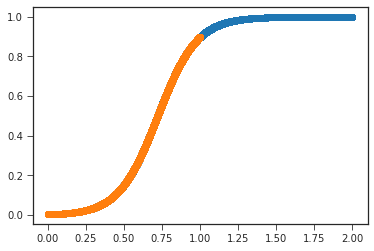

In [88]:
plt.scatter(si, yi)
plt.scatter(sf, yf)

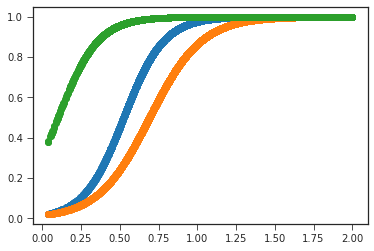

In [89]:
plt.scatter(si, logistic(si, 0.1, b, c))
plt.scatter(si, logistic(si, a, 6, c))
plt.scatter(si, logistic(si, a, b, 0.2))

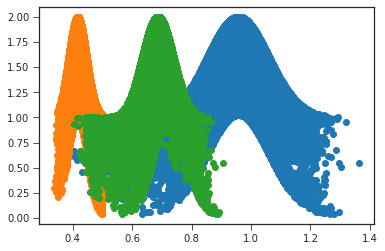

In [161]:
plt.scatter(down_sbs[:, 46], si)
plt.scatter(down_sbs[:, 47], si)
plt.scatter((down_sbs[:, 46] + down_sbs[:, 47]) * 0.5, si)

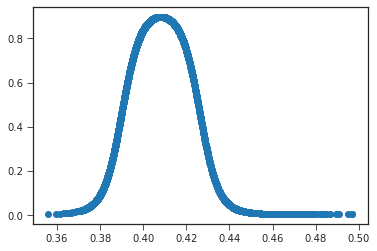

In [91]:
plt.scatter(up_sbs[:, 42], yf)
plt.scatter(
    up_sbs[
        :,
    ]
)

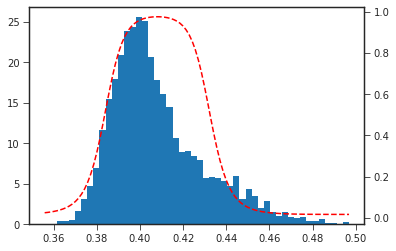

In [156]:
plt.hist(up_sbs[:, 42], density=True, bins=50)
plt.twinx()
x = np.linspace(np.min(up_sbs[:, 42]), np.max(up_sbs[:, 42]), 100)
s = S(np.expand_dims(x, axis=1), up_stats[0, 0], up_stats[0, 1])
y = logistic(s, 0.1, b, c)
plt.plot(x, y, "r--")
# plt.twinx()
# plt.plot(s, y, 'g-.')

(array([4.54310779, 1.70820853, 1.0297711 , 1.12669097, 0.81170176,
        0.70266749, 0.59363288, 0.64209243, 0.82381671, 0.48459806,
        0.59363312, 0.46036816, 0.50882797, 0.50882797, 0.53305831,
        0.54517237, 0.58151816, 0.60574808, 0.39979307, 0.49671343,
        0.58151816, 0.33921836, 0.55728824, 0.53305831, 0.6420919 ,
        0.52094335, 0.47248272, 0.46036854, 0.67843672, 0.55728917,
        0.69055167, 0.48459766, 0.54517418, 0.77535626, 0.61786202,
        0.84804873, 0.55728731, 0.7874712 , 0.84804873, 0.96919532,
        1.00554014, 0.9934252 , 1.10246335, 1.35687345, 1.29629874,
        1.6718675 , 2.19280441, 2.33818371, 4.19178373, 9.58291873]),
 array([0.00367849, 0.02156809, 0.03945769, 0.05734729, 0.07523689,
        0.09312649, 0.11101609, 0.12890568, 0.14679529, 0.16468489,
        0.1825745 , 0.20046408, 0.21835369, 0.2362433 , 0.2541329 ,
        0.2720225 , 0.2899121 , 0.3078017 , 0.32569128, 0.3435809 ,
        0.3614705 , 0.37936008, 0.3972497 , 0.

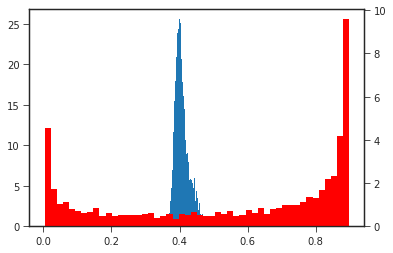

In [159]:
plt.hist(up_sbs[:, 42], density=True, bins=50)
plt.twinx()
plt.hist(logistic(sf, a, b, c), density=True, bins=50, color="red")

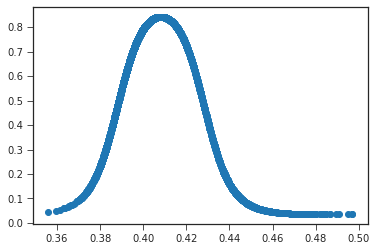

In [112]:
plt.scatter(up_sbs[:, 42], logistic(sf, a, 5, c))

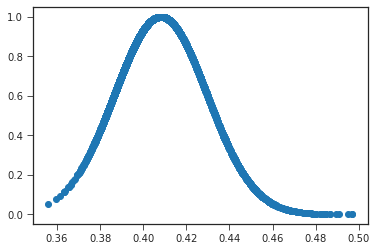

In [160]:
plt.scatter(up_sbs[:, 42], sf)

In [74]:
logistic(0.41, a, b, c)

0.08216628240529524

(array([ 183.,  144.,  174.,  201.,  240.,  326.,  439.,  528.,  684.,
        1695.]),
 array([1.93257874e-04, 1.00173935e-01, 2.00154603e-01, 3.00135285e-01,
        4.00115967e-01, 5.00096619e-01, 6.00077331e-01, 7.00057983e-01,
        8.00038636e-01, 9.00019348e-01, 1.00000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

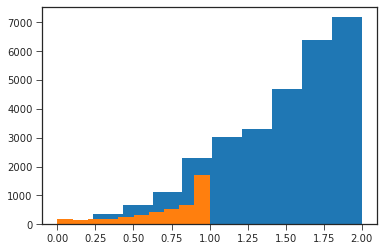

In [73]:
plt.hist(si)
plt.hist(sf)

In [75]:
si = S(sb_arr[:, [46, 47]], down_stats[1:, 0], down_stats[1:, 1])

sf = S(sb_arr[:, [42]], up_stats[0, 0], up_stats[0, 1])

(array([1974436.,  137477.,   99574.,   85680.,   81294.,   82605.,
          87648.,   96675.,  114945.,  239666.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

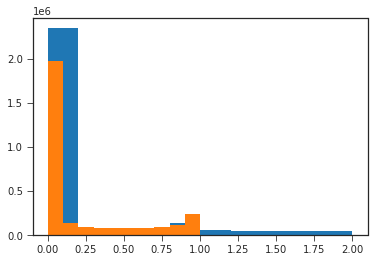

In [76]:
plt.hist(si)
plt.hist(sf)